# Neurális háló tanítása személygépjárművek felismerésére

### Szükséges kiegészítő függvénykönyvtárak importálása

In [1]:
import os #mappa létrehozása, azonosítása vagy tartalmának lekérdezése
import time #idővel kaocsolatos manipulációk 
import math # matematikai függvények listája
import shutil #fájlok módosításához, eltávolításához
import matplotlib.pyplot as plt #képen az eredményt ábrázolása
import tensorflow as tf #numerikus számítások
from tensorflow.keras import layers #számítási függvényeket tartalmazó rétegek behívása 
from sklearn.model_selection import train_test_split #bemenetként megadott tömbök részhalmazokra osztása

### Tanításhoz használt adathalmazok elérési útjának megadása

In [2]:
JARMUVEK = r'C:\Users\Eszti\Desktop\Python projects\cardata\KITTI_vehicles'
NEM_JARMUVEK = r'C:\Users\Eszti\Desktop\Python projects\cardata\non-vehicles'

### Tanításhoz mappák definiálása

In [4]:
jarmu_kepek_neve = os.listdir(JARMUVEK)
nem_jarmu_kepek_neve = os.listdir(NEM_JARMUVEK)

### Mappában található képekről információk kiíratása

In [6]:
print('Járműveket tartalmazó képek száma:', len(jarmu_kepek_neve))
print('Járműveket nem tartalmazó képek száma:', len(nem_jarmu_kepek_neve))
print(jarmu_kepek_neve[:10])
print(nem_jarmu_kepek_neve[:10])

Járműveket tartalmazó képek száma: 5967
Járműveket nem tartalmazó képek száma: 8968
['.DS_Store', '1.png', '10.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
['extra1.png', 'extra10.png', 'extra100.png', 'extra1000.png', 'extra1001.png', 'extra1002.png', 'extra1003.png', 'extra1004.png', 'extra1005.png', 'extra1006.png']


### Könyvtárak definiálása tanításhoz és teszteléshez

In [7]:
Fo_konyvtar = '../tmp/'
Train_konyvtar = os.path.join(Fo_konyvtar, 'tanítás')
Teszt_konyvtar = os.path.join(Fo_konyvtar, 'tesztelés')
Jarmuvek_Train_konyvtar = os.path.join(Train_konyvtar, 'járművek')
Nem_Jarmuvek_Train_konyvtar = os.path.join(Teszt_konyvtar, 'nem járművek')
Jarmuvek_Teszt_konyvtar = os.path.join(Teszt_konyvtar, 'járművek')
Nem_Jarmuvek_Teszt_konyvtar = os.path.join(Teszt_konyvtar, 'nem járművek')

### Adathalmaz tanításban résztvevő arányának megadása

In [8]:
TRAIN_MERET = 0.8

### Tanító és tesztelő halmazokban a képek random keverése

In [10]:
train_jarmuvek, teszt_jarmuvek = train_test_split(
    jarmu_kepek_neve, train_size=TRAIN_MERET, shuffle=True, random_state=1)

train_nem_jarmuvek, teszt__nem_jarmuvek = train_test_split(
    nem_jarmu_kepek_neve, train_size=TRAIN_MERET, shuffle=True, random_state=1)

### Lista elemszámainak kiíratása

In [11]:
print('Járművet tart. képek száma tanításhoz:', len(train_jarmuvek))
print('Járművet nem tart. képek száma tanításhoz:', len(train_nem_jarmuvek))

print('Járművet tart. képek száma teszteléshez:', len(teszt_jarmuvek))
print('Járművet nem tart. képek száma teszteléshez:', len(teszt__nem_jarmuvek))

Járművet tart. képek száma tanításhoz: 4773
Járművet nem tart. képek száma tanításhoz: 7174
Járművet tart. képek száma teszteléshez: 1194
Járművet nem tart. képek száma teszteléshez: 1794


### Adathalmazok szétbontása

In [17]:
def move_images(image_list, old_dir_path, new_dir_path):
    if not os.path.exists(new_dir_path):
        os.makedirs(new_dir_path)
    
    for file_name in image_list:
        shutil.copy(
            os.path.join(old_dir_path, file_name),
            os.path.join(new_dir_path, file_name)
        )
    print(f'{len(image_list)} IMAGES COPIED TO {new_dir_path}')

### Képek mozgatása a megfelelő mappákba

In [18]:
move_images(train_jarmuvek, JARMUVEK, Jarmuvek_Train_konyvtar)
move_images(train_nem_jarmuvek, NEM_JARMUVEK, Nem_Jarmuvek_Train_konyvtar)

move_images(teszt_jarmuvek, JARMUVEK, Jarmuvek_Train_konyvtar)
move_images(teszt__nem_jarmuvek, NEM_JARMUVEK, Nem_Jarmuvek_Train_konyvtar)

4773 IMAGES COPIED TO ../tmp/tanítás\járművek
7174 IMAGES COPIED TO ../tmp/tesztelés\nem járművek
1194 IMAGES COPIED TO ../tmp/tanítás\járművek
1794 IMAGES COPIED TO ../tmp/tesztelés\nem járművek


### Tanításhoz használt mappa elemszáma

In [19]:
len(os.listdir(Jarmuvek_Train_konyvtar))

8793

### Kép mérete

In [20]:
IMG_SIZE = 256

### Bemeneti adatok normalizálása (tanítás közbeni adatbővítés)

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    Train_konyvtar,
    target_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    class_mode='binary')

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    Teszt_konyvtar,
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='binary')

Found 15966 images belonging to 2 classes.
Found 10727 images belonging to 2 classes.


### Konvolúciós neurális háló alkalmazása

In [22]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D(2, 2),
    layers.Flatten(),
    layers.Dense(1, activation='sigmoid')])

model.summary()

model.compile(
    optimizer='adam', #gradiens süllyedés optimalizálása
    loss='binary_crossentropy', #veszteség függvény
    metrics=['accuracy']) #pontossági mutató

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 1)                 2

### Tanítás leállításának meghatározása

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)  #ha már nem érhető el további javulás

model_path = r'C:\Users\Eszti\Desktop\Python projects\teszt/vehicle_detection.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path,
    save_best_only=True)

### Tanítás (iterációk) indítása

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=5,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
499/499 [==============================] - 729s 1s/step - loss: 0.2026 - accuracy: 0.9172 - val_loss: 0.2758 - val_accuracy: 0.9009
Epoch 2/5
499/499 [==============================] - 690s 1s/step - loss: 0.0718 - accuracy: 0.9756 - val_loss: 0.0725 - val_accuracy: 0.9795
Epoch 3/5
499/499 [==============================] - 717s 1s/step - loss: 0.0513 - accuracy: 0.9830 - val_loss: 0.0380 - val_accuracy: 0.9897
Epoch 4/5
499/499 [==============================] - 722s 1s/step - loss: 0.0393 - accuracy: 0.9862 - val_loss: 0.0237 - val_accuracy: 0.9928
Epoch 5/5
499/499 [==============================] - 754s 2s/step - loss: 0.0282 - accuracy: 0.9894 - val_loss: 0.0120 - val_accuracy: 0.9961


### Pontossági mutatók kijelzése

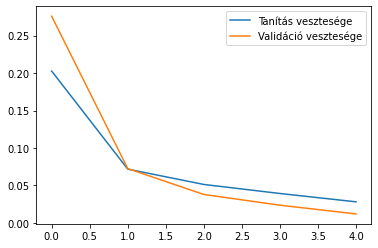

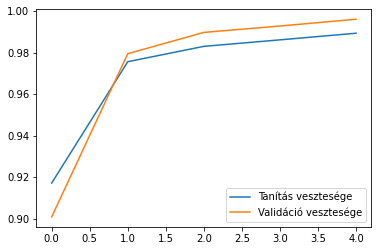

In [28]:
plt.plot(history.history['loss'], label='Tanítás vesztesége')
plt.plot(history.history['val_loss'], label='Validáció vesztesége')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Tanítás vesztesége')
plt.plot(history.history['val_accuracy'], label='Validáció vesztesége')
plt.legend()
plt.show()